In [1]:
# !pip install scrinet

In [2]:
# import sys
# sys.path.insert(0, '/Users/spx8sk/work/git/stk/scrinet/')

In [3]:
# from google.colab import drive
# drive.mount('/content/gdrive/')

In [4]:
# %%capture
# !pip install arviz
# !pip install george
# !pip install forked-rompy
# !pip install gw_phenom==1.0.1
# !pip install lalsuite==6.68
# !pip install PyCondor
# !pip install schwimmbad
# !pip install bilby
# # !pip install tensorflow
# # !pip install tensorflow-probability

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
# import sys
# sys.path.append('/content/gdrive/My Drive/NN_for_PE/scrinet')

In [7]:
import numpy as np
# import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az

import tensorflow as tf
import tensorflow_probability as tfp

from tensorflow import keras
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split

# import tensorflow_docs as tfdocs
# import tensorflow_docs.plots
# import tensorflow_docs.modeling

import scrinet.sample.sample_helpers as nn_help
import scrinet.sample.likelihood as likelihood
import scrinet.sample.kernels as kernel_helper


from scrinet.greedy import greedyrb
from scrinet.surrogate import surrogate
from scrinet.fits import nn, scale
from scrinet.interfaces import lalutils
from scrinet.analysis import utils as ut

from scrinet.analysis.timeseries_batch import TimeSeries
from scrinet.analysis.frequencyseries_batch import FrequencySeries
from scrinet.analysis import matchedfilter_batch as matchedfilter

from scrinet.workflow.pipe_utils import (
    init_logger,
    load_data,
    match,
    wave_sur_many,
    load_model,
)

from scrinet.workflow import generators
import schwimmbad
import functools
import tqdm
import os
import scrinet
import time

In [8]:
# sns.set_context("poster")
# sns.set_style("darkgrid")

In [9]:
tfb = tfp.bijectors
tfd = tfp.distributions

In [12]:
# rootdir = "/content/gdrive/My Drive/NN_for_PE/3D_NP"
# rootdir = "/Users/spx8sk/work/data/scrinet/3D_NP"
rootdir = '/Users/Rhys/Documents/PhD/PE/NN_for_PE/3D_NP'

## Load ANN-SUR

In [13]:
amp_basis = os.path.join(rootdir, "rb/amp/amp_eim_basis.npy")
amp_model_dir = os.path.join(rootdir, "ts/amp/fits")

phase_basis = os.path.join(rootdir, "rb/phase/phase_eim_basis.npy")
phase_model_dir = os.path.join(rootdir, "ts/phase/fits")

In [14]:
amp_model, amp_basis = load_model(
    basis_file=amp_basis,
    nn_weights_file=os.path.join(amp_model_dir, "best.h5"),
    X_scalers_file=os.path.join(amp_model_dir, "X_scalers.npy"),
    Y_scalers_file=os.path.join(amp_model_dir, "Y_scalers.npy"),
)

phase_model, phase_basis = load_model(
    basis_file=phase_basis,
    nn_weights_file=os.path.join(phase_model_dir, "best.h5"),
    X_scalers_file=os.path.join(phase_model_dir, "X_scalers.npy"),
    Y_scalers_file=os.path.join(phase_model_dir, "Y_scalers.npy"),
)

In [15]:
amp_basis = tf.convert_to_tensor(amp_basis, dtype = tf.float32)
phase_basis = tf.convert_to_tensor(phase_basis, dtype = tf.float32)

## Generate waveform

In [16]:
params = tf.constant(
    [2.0, 0.1, 0.2, 0.1, 0.5, 0.2, 1.1, 0.], dtype=tf.float64, shape=(1, 8)
)

params = tf.convert_to_tensor(params)

In [17]:
# true_q = tf.convert_to_tensor(true_q)
# true_q = tf.cast(true_q, tf.float32)

In [18]:
y_true = ut.tf_generate_surrogate_at_detector(
    params,
    amp_model=amp_model,
    amp_basis=amp_basis,
    phase_model=phase_model,
    phase_basis=phase_basis,
)

In [19]:
psd = tf.ones_like(y_true[0])
times = np.linspace(-10000, 100, 5000)

dt = times[1] - times[0]
n = len(times)
df = 1.0 / (n * dt)
norm = 4.0 * df
dt = tf.cast(dt, tf.float32)

In [1]:
import numpy as np
times = np.linspace(-10000, 100, 5000)

dt = times[1] - times[0]

In [2]:
dt

2.020404080816661

In [20]:
y_true = tf.constant(y_true)
y_true = y_true + tf.random.normal(mean=0, stddev=0.01, shape=(len(y_true[0]),))

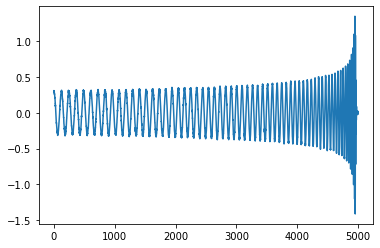

In [21]:
plt.plot(y_true.numpy().flatten())

In [22]:
y_true = tf.constant(y_true)

In [23]:
psd = tf.ones_like(y_true)
times = np.linspace(-10000, 100, 5000)

dt = times[1] - times[0]
n = len(times)
df = 1.0 / (n * dt)
norm = 4.0 * df

dt = 1.0

In [33]:
likelihood.simple_gw_prior??

In [25]:
# @tf.function(experimental_compile=True, autograph=False, experimental_relax_shapes=True)
def target_log_prob_fn(x):
    log_like = likelihood.simple_gw_log_like(y_true,
                          x,
                          amp_model= amp_model,
                          amp_basis =amp_basis, 
                          phase_model = phase_model,
                          phase_basis = phase_basis, 
                          dt = dt, 
                          epoch = times[0])
    log_like = tf.cast(log_like, tf.float32)
    log_prior = likelihood.simple_gw_prior(x)
    # tf.print(log_prior)
    prob = log_like + log_prior
    # prob = log_like   
    # tf.print(log_like)
    # tf.print(x)
    # tf.print(min(prob))
    #tf.print(prob[tf.math.argmin(prob)])
    #tf.print(x[tf.math.argmin(prob)])
    # tf.print(tf.multiply(prob, 0.0001))
    return tf.multiply(prob, 0.0001)


In [26]:
num_chains = 2
ndim = 3

In [27]:
p0 = [
    [
        tf.random.uniform(shape=(1,), minval=0.0, maxval=1.0).numpy()[0],
        tf.random.uniform(shape=(1,), minval=0.0, maxval=1.0).numpy()[0],
        tf.random.uniform(shape=(1,), minval=0.0, maxval=1.0).numpy()[0],
        tf.random.uniform(shape=(1,), minval=0.0, maxval=1.0).numpy()[0],
        tf.random.uniform(shape=(1,), minval=0.0, maxval=1.0).numpy()[0],
        tf.random.uniform(shape=(1,), minval=0.0, maxval=1.0).numpy()[0],
        tf.random.uniform(shape=(1,), minval=0.0, maxval=1.0).numpy()[0],
        tf.random.uniform(shape=(1,), minval=0.0, maxval=1.0).numpy()[0]
    ]
    for i in range(num_chains)
]

In [28]:
p0 = tf.convert_to_tensor(p0)
p0 = tf.cast(p0, tf.float32)

In [29]:
p0.shape

TensorShape([2, 8])

In [37]:
qs = np.linspace(0.125, 1, 10**2+ 1)

In [61]:
p = params.numpy()
p[:,0] = 0.2
p = tf.convert_to_tensor(p)
p = tf.cast(p, tf.float32)

In [62]:
params

<tf.Tensor: shape=(1, 8), dtype=float64, numpy=array([[2. , 0.1, 0.2, 0.1, 0.5, 0.2, 1.1, 0. ]])>

In [63]:
target_log_prob_fn(p)

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([-120.567825], dtype=float32)>

In [64]:
probs = []
for q in qs:
    p = params.numpy()
    p[:,0] = 2./8
    p[:,5] = q
    p = tf.convert_to_tensor(p)
    p = tf.cast(p, tf.float32)
    probs.append(target_log_prob_fn(p))

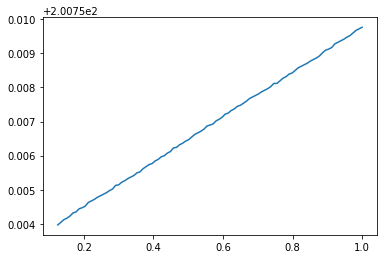

In [65]:
plt.plot(qs, probs)

In [101]:
constraints = tfb.Sigmoid(low =  [0., 0., 0., 0., -np.pi/2, 0., 0., 0.], 
                          high = [1., 1., 1., 2*np.pi, np.pi/2, 1., 2 *np.pi, 2*np.pi ])

## Fit bijector with variational inference

In [ ]:
made = tfb.AutoregressiveNetwork(params=2, hidden_units=[1024,1024,1024,
                                                         ], activation = 'tanh')

distribution = tfd.TransformedDistribution(
    distribution=tfd.MultivariateNormalDiag(tf.zeros_like(p0[0]), tf.ones_like(p0[0])),
    bijector= tfb.Chain([constraints,tfb.MaskedAutoregressiveFlow(made)]))

In [ ]:
def elbo_loss():
  q_samples = distribution.sample(128)
  # print(f' samples : {q_samples}')
  # print(f' true : {target_log_prob_fn(q_samples)}')
  # print(f' surrogate: {distribution.log_prob(q_samples)}')
  # print(f'loss { -tf.reduce_mean(target_log_prob_fn(q_samples) - distribution.log_prob(q_samples))}')
  return -tf.reduce_mean(
  target_log_prob_fn(q_samples) - distribution.log_prob(q_samples))


In [ ]:
optimiser = tf.optimizers.Adam(lr=0.001,
                                amsgrad = True, 
                                clipnorm=0.0001)

In [ ]:
# optimiser.get_gradients(elbo_loss(), distribution.trainable_variables)

In [ ]:
# optimiser.get_updates(elbo_loss(), distribution.trainable_variables)

In [ ]:
n_training_steps = 1 * 10**3

In [ ]:
losses = []

In [ ]:
%%time
for i in range(n_training_steps):
  optimiser.minimize(elbo_loss, distribution.trainable_variables)
  loss = elbo_loss()
  losses.append(loss)
  if i% 200 ==0:
    print(f' finishing step {i}, loss = {np.mean(losses[-20:])}') 
  if np.isnan(loss):
     raise ValueError

 finishing step 0, loss = 186.1165771484375
 finishing step 200, loss = 6.984175682067871
 finishing step 400, loss = -22.51862144470215
 finishing step 600, loss = -58.83324432373047
 finishing step 800, loss = -115.33648681640625
CPU times: user 9min 3s, sys: 1min 10s, total: 10min 13s
Wall time: 9min 38s


Text(0.5, 0, 'num training steps')

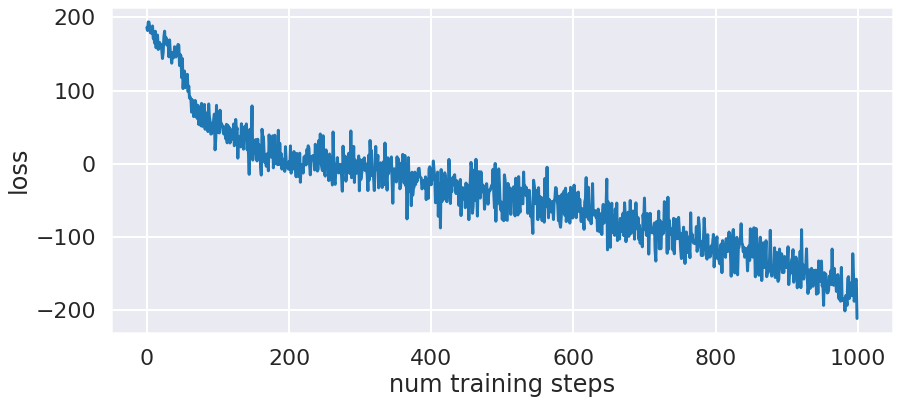

In [ ]:
plt.figure(figsize = (14,6))
plt.plot(losses)
# plt.yscale('log')
plt.ylabel('loss')
plt.xlabel('num training steps')
# plt.ylim(0,200)

In [ ]:
# %%time
# loss = tfp.vi.fit_surrogate_posterior(
#     target_log_prob_fn,
#     surrogate_posterior=distribution,
#     optimizer=tf.optimizers.Adam(lr=learning_rate,
#                                  amsgrad = True, 
#                                  clipvalue= 0.5),
#     sample_size = 256,
#     num_steps= n_training_steps,
#     trainable_variables = distribution.bijector.trainable_variables)
# # print(f' finishing step {step}, loss = {np.mean(losses[-1])

In [ ]:
# plt.figure(figsize = (14,6))
# plt.plot(loss)
# # plt.yscale('log')
# plt.ylabel('loss')
# plt.xlabel('num training steps')

In [ ]:
smp = distribution.sample(5 * 10**3)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

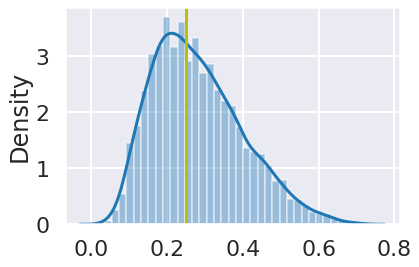

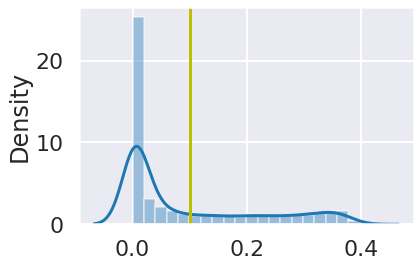

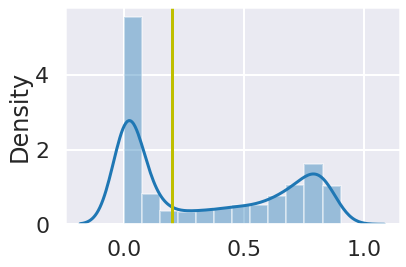

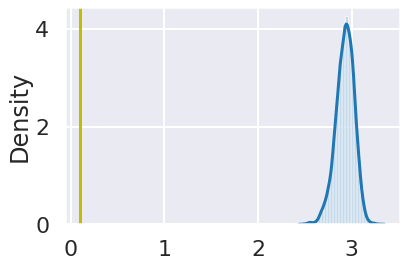

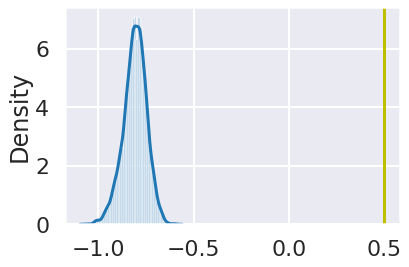

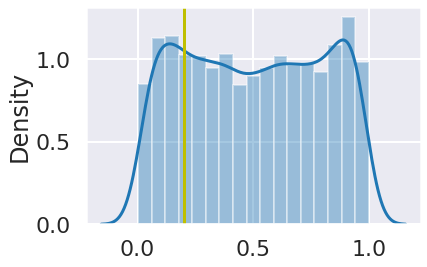

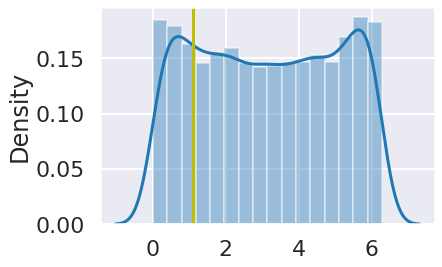

In [ ]:
for i, val in enumerate(params[0].numpy()):
  plt.figure()
  sns.distplot(smp.numpy().T[i].flatten())
  # sns.distplot(non_bij_chains.numpy().T[i].flatten())
  if i ==0:
    plt.axvline(val / 8, color = 'y', label = 'true')
  else : 
    plt.axvline(val, color = 'y', label = 'true')


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


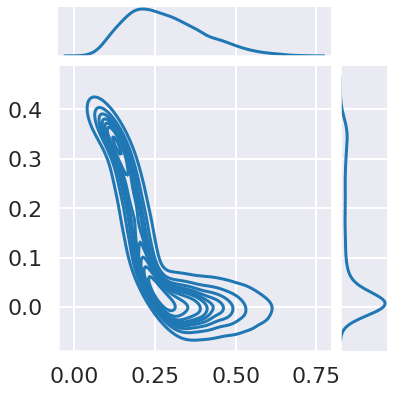

In [ ]:
sns.jointplot(smp[:,0], smp[:,1], kind = 'kde')

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


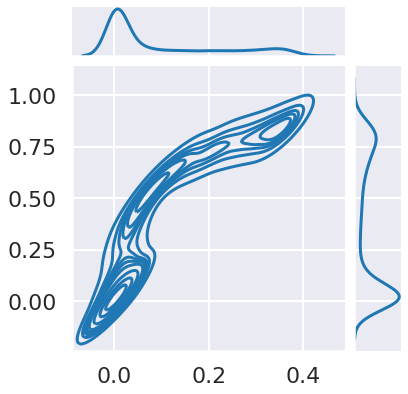

In [ ]:
sns.jointplot(smp[:,1], smp[:,2], kind = 'kde')


## Let's sample with and without the learnt bijector and compare

In [102]:
@tf.function(experimental_compile = True, autograph=False)
def do_sampling(
    target_log_prob_fn,
    p0 = p0,
    num_results=  5* 10 ** 3,
    num_burnin_steps=2* 10 ** 3,
    ndim=3,
    step_size=0.05,
    sampler = 'HMC',
    bijector = True,
    step_size_adapter = 'simple',
    num_leapfrog_steps = 10,
    max_tree_depth = 8,
    parallel_iterations=20,
    target_accept_prob = 0.7,
    ):
  
    if sampler == 'HMC':
      inner_kernel = tfp.mcmc.SimpleStepSizeAdaptation(
          tfp.mcmc.HamiltonianMonteCarlo(
              target_log_prob_fn = target_log_prob_fn,
              step_size = 0.01,
              num_leapfrog_steps = 10),
          num_adaptation_steps= int(0.75 *num_burnin_steps ))

    elif sampler == 'MCMC':
      inner_kernel = tfp.mcmc.RandomWalkMetropolis(
          target_log_prob_fn = target_log_prob_fn, 
          new_state_fn = tfp.mcmc.random_walk_uniform_fn(scale=0.01,
)
                                                   )
    else: 
      raise ValueError('kernel not implemented')

    if bijector:
      
      kernel=tfp.mcmc.TransformedTransitionKernel(
          inner_kernel= inner_kernel,
          bijector=distribution.bijector)
    
    else : 
       print('not using learnt bijector')
       kernel=tfp.mcmc.TransformedTransitionKernel(
           inner_kernel=inner_kernel,
           bijector=tfb.Identity())
        
    posterior = tfp.mcmc.sample_chain(
        num_results=num_results,
        num_burnin_steps=num_burnin_steps,
        current_state=p0,
        return_final_kernel_results=True,
        kernel=kernel,
    )

    return posterior

### Let's first compare MCMC and HMC

In [108]:
%%time
mcmc_results = do_sampling(target_log_prob_fn = target_log_prob_fn,
                      num_results=  20 * 10 ** 3,
                      num_burnin_steps= 20* 10 ** 3,
                      sampler = 'MCMC', 
                      bijector = False,
                      )
mcmc_trace = mcmc_results.trace
p_accept = tf.reduce_mean(tf.exp(tf.minimum(mcmc_trace.inner_results.log_accept_ratio, 0.0)))
# p_accept = tf.reduce_mean(tf.exp(tf.minimum(bij_trace.inner_results.inner_results.log_accept_ratio, 0.0)))
print(f"Acceptance rate: {p_accept}")

not using learnt bijector


2020-12-17 12:06:06,146 - WARNING - 9 out of the last 9 calls to <function x_scale_hack at 0x1a404d5320> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


2020-12-17 12:06:06,179 - WARNING - 9 out of the last 9 calls to <function get_model_y_mean_scalers at 0x1a404d5560> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


2020-12-17 12:06:06,185 - WARNING - 9 out of the last 9 calls to <function get_model_y_std_scalers at 0x1a404d5440> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


2020-12-17 12:06:06,193 - WARNING - 9 out of the last 9 calls to <function y_inv_scale_hack at 0x1a404d5680> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


2020-12-17 12:06:06,217 - WARNING - 10 out of the last 10 calls to <function x_scale_hack at 0x1a404d5320> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


2020-12-17 12:06:06,251 - WARNING - 10 out of the last 10 calls to <function get_model_y_mean_scalers at 0x1a404d5560> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


2020-12-17 12:06:06,257 - WARNING - 10 out of the last 10 calls to <function get_model_y_std_scalers at 0x1a404d5440> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


2020-12-17 12:06:06,262 - WARNING - 10 out of the last 10 calls to <function y_inv_scale_hack at 0x1a404d5680> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


2020-12-17 12:06:06,275 - WARNING - 5 out of the last 1019 calls to <function predict_hack at 0x1a40473cb0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.
/Users/spx8sk/anaconda3/envs/scrinet-dev/lib/python3.7/site-packages/tensorflow_probability/python/mcmc/sample.py:333: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


Acceptance rate: 0.19675368070602417
CPU times: user 3min 25s, sys: 6.81 s, total: 3min 31s
Wall time: 3min


In [ ]:
# %%time
# hmc_results = do_sampling(target_log_prob_fn = target_log_prob_fn,
#                       num_results=  8 * 10 ** 3,
#                       num_burnin_steps= 8* 10 ** 3,
#                       sampler = 'HMC', 
#                       bijector = False,
#                       )
# hmc_trace = hmc_results.trace
# # p_accept = tf.reduce_mean(tf.exp(tf.minimum(hmc_trace.inner_results.log_accept_ratio, 0.0)))
# p_accept = tf.reduce_mean(tf.exp(tf.minimum(hmc_trace.inner_results.inner_results.log_accept_ratio, 0.0)))
# print(f"Acceptance rate: {p_accept}")

not using learnt bijector
Instructions for updating:
The `step_size_update_fn` argument is deprecated. Use `tfp.mcmc.SimpleStepSizeAdaptation` instead.


2020-12-16 15:46:54,078 - WARNING - From /usr/local/lib/python3.6/dist-packages/tensorflow_probability/python/mcmc/kernel.py:104: calling HamiltonianMonteCarlo.__init__ (from tensorflow_probability.python.mcmc.hmc) with step_size_update_fn is deprecated and will be removed after 2019-05-22.
Instructions for updating:
The `step_size_update_fn` argument is deprecated. Use `tfp.mcmc.SimpleStepSizeAdaptation` instead.


Instructions for updating:
The `seed` argument is deprecated (but will work until removed). Pass seed to `tfp.mcmc.sample_chain` instead.


2020-12-16 15:46:54,080 - WARNING - From /usr/local/lib/python3.6/dist-packages/tensorflow/python/util/deprecation.py:507: calling HamiltonianMonteCarlo.__init__ (from tensorflow_probability.python.mcmc.hmc) with seed is deprecated and will be removed after 2020-09-20.
Instructions for updating:
The `seed` argument is deprecated (but will work until removed). Pass seed to `tfp.mcmc.sample_chain` instead.
/usr/local/lib/python3.6/dist-packages/tensorflow_probability/python/mcmc/sample.py:338: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


Acceptance rate: 0.727408230304718
CPU times: user 8min 53s, sys: 2min 51s, total: 11min 44s
Wall time: 11min 47s


In [109]:
mcmc_chains = mcmc_results.all_states
# hmc_chains = hmc_results.all_states


In [110]:
mcmc_data = nn_help.convert_tfp_chains_to_arviz_object(mcmc_chains)
# hmc_data = nn_help.convert_tfp_chains_to_arviz_object(hmc_chains)

In [111]:
az.summary(mcmc_data)

mean     sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
x[0]  0.975  0.020   0.936    1.000      0.009    0.007       5.0     5.0   
x[1]  0.123  0.106   0.000    0.248      0.074    0.062       2.0     2.0   
x[2]  0.470  0.292   0.000    0.858      0.198    0.164       2.0     2.0   
x[3]  0.087  0.066   0.000    0.204      0.014    0.010      21.0    21.0   
x[4]  0.958  0.143   0.721    1.234      0.076    0.059       4.0     4.0   
x[5]  0.599  0.167   0.243    0.870      0.102    0.082       3.0     3.0   
x[6]  1.060  0.120   0.840    1.272      0.039    0.029      10.0     9.0   
x[7]  0.823  0.294   0.408    1.339      0.193    0.161       2.0     2.0   

      ess_bulk  ess_tail  r_hat  
x[0]       5.0     132.0   1.31  
x[1]       3.0      56.0   1.89  
x[2]       3.0      22.0   2.27  
x[3]      22.0      43.0   1.10  
x[4]       4.0      11.0   1.48  
x[5]       3.0      11.0   1.99  
x[6]      10.0      30.0   1.14  
x[7]       3.0      18.0   2.11

In [ ]:
# az.summary(hmc_data)

mean     sd  hdi_3%  hdi_97%  ...  ess_sd  ess_bulk  ess_tail  r_hat
x[0]  0.250  0.004   0.242    0.257  ...   493.0     504.0     801.0   1.00
x[1]  0.132  0.040   0.050    0.197  ...     6.0       7.0      19.0   1.24
x[2]  0.122  0.093   0.000    0.302  ...     5.0       6.0      14.0   1.28
x[3]  0.011  0.011   0.000    0.032  ...   674.0     937.0     939.0   1.00
x[4]  0.822  0.037   0.752    0.895  ...   103.0     108.0     152.0   1.02
x[5]  0.642  0.245   0.104    0.993  ...     3.0       3.0      11.0   1.65
x[6]  0.698  0.373   0.013    1.321  ...     2.0       3.0      11.0   2.06

[7 rows x 11 columns]

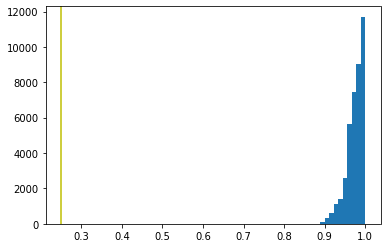

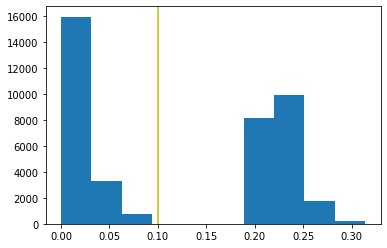

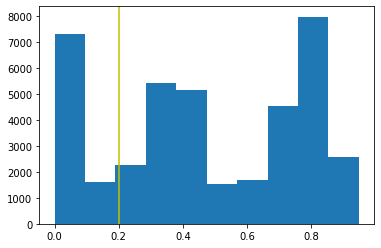

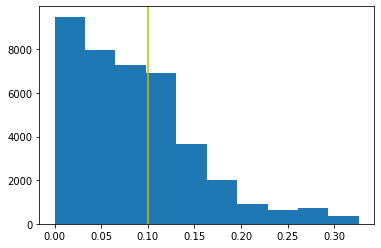

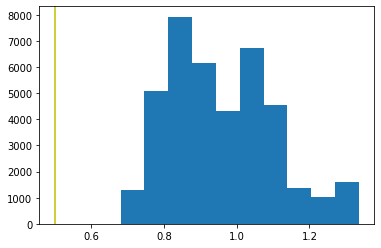

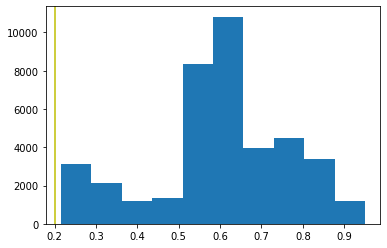

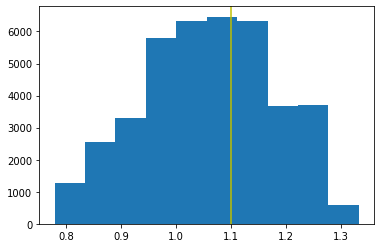

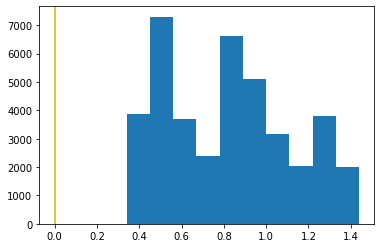

In [112]:
for i, val in enumerate(params[0].numpy()):
    plt.figure()
    plt.hist(mcmc_chains.numpy().T[i].flatten())
    # sns.distplot(non_bij_chains.numpy().T[i].flatten())
    if i ==0:
        plt.axvline(val / 8, color = 'y', label = 'true')
    else : 
        plt.axvline(val, color = 'y', label = 'true')


In [ ]:
%%time
bij_mcmc_results = do_sampling(target_log_prob_fn = target_log_prob_fn,
                      num_results=  20 * 10 ** 3,
                      num_burnin_steps=20 * 10 ** 3,
                      sampler = 'MCMC',
                      bijector = True)
bij_mcmc_trace = bij_mcmc_results.trace
p_accept = tf.reduce_mean(tf.exp(tf.minimum(bij_mcmc_trace.inner_results.log_accept_ratio, 0.0)))
print(f"Acceptance rate: {p_accept}")

/usr/local/lib/python3.6/dist-packages/tensorflow_probability/python/mcmc/sample.py:338: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


Acceptance rate: 0.9745119214057922
CPU times: user 2min 40s, sys: 50.5 s, total: 3min 31s
Wall time: 3min 32s


In [ ]:
%%time
bij_hmc_results = do_sampling(target_log_prob_fn = target_log_prob_fn,
                      num_results=  8 * 10 ** 3,
                      num_burnin_steps=8* 10 **3,
                      sampler = 'HMC',
                      bijector = True)
bij_hmc_trace = bij_hmc_results.trace
p_accept = tf.reduce_mean(tf.exp(tf.minimum(bij_hmc_trace.inner_results.inner_results.log_accept_ratio, 0.0)))
print(f"Acceptance rate: {p_accept}")

/usr/local/lib/python3.6/dist-packages/tensorflow_probability/python/mcmc/sample.py:338: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


Acceptance rate: 0.7442973852157593
CPU times: user 37min 51s, sys: 13min 8s, total: 51min
Wall time: 51min 2s


In [ ]:
bij_mcmc_chains = bij_mcmc_results.all_states
bij_hmc_chains = bij_hmc_results.all_states



In [ ]:
bij_mcmc_data = nn_help.convert_tfp_chains_to_arviz_object(bij_mcmc_chains)
bij_hmc_data = nn_help.convert_tfp_chains_to_arviz_object(bij_hmc_chains)

In [ ]:
az.summary(bij_mcmc_data)

mean     sd  hdi_3%  hdi_97%  ...  ess_sd  ess_bulk  ess_tail  r_hat
x[0]  0.542  0.332   0.202    0.880  ...     2.0       3.0      21.0   1.84
x[1]  0.111  0.080   0.010    0.217  ...     2.0       3.0      14.0   2.06
x[2]  0.484  0.288   0.109    0.788  ...     2.0       3.0      33.0   2.03
x[3]  0.076  0.049   0.027    0.157  ...     2.0       3.0      25.0   2.31
x[4]  0.676  0.273   0.349    1.013  ...     2.0       3.0      24.0   2.43
x[5]  0.138  0.115   0.011    0.308  ...     2.0       3.0      17.0   2.02
x[6]  1.510  0.918   0.291    2.883  ...     2.0       3.0      12.0   2.02

[7 rows x 11 columns]

In [ ]:
az.summary(bij_hmc_data)

mean     sd  hdi_3%  hdi_97%  ...  ess_sd  ess_bulk  ess_tail  r_hat
x[0]  0.249  0.004   0.241    0.256  ...  2912.0    2937.0    2377.0   1.00
x[1]  0.053  0.037   0.001    0.121  ...    15.0      12.0      64.0   1.13
x[2]  0.326  0.094   0.141    0.480  ...    15.0      16.0     182.0   1.10
x[3]  0.017  0.012   0.002    0.037  ...    69.0      74.0     182.0   1.01
x[4]  0.831  0.038   0.761    0.903  ...  4345.0    4368.0    5147.0   1.00
x[5]  0.499  0.288   0.027    0.960  ...  8673.0    8043.0    7038.0   1.00
x[6]  3.197  1.790   0.371    5.997  ...  2657.0    3144.0    5852.0   1.00

[7 rows x 11 columns]

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

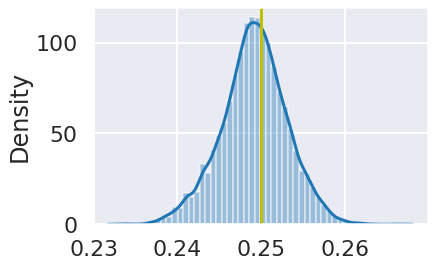

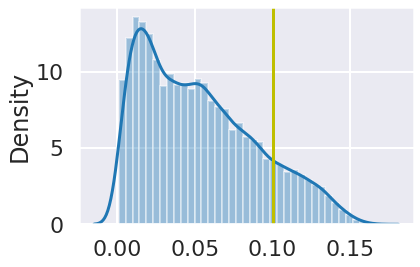

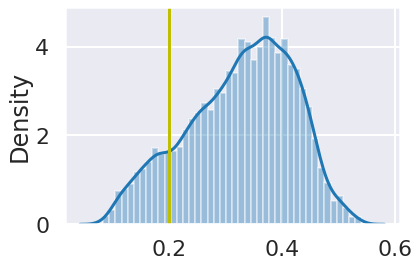

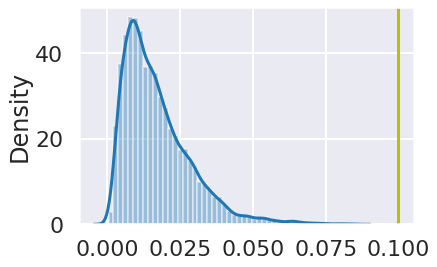

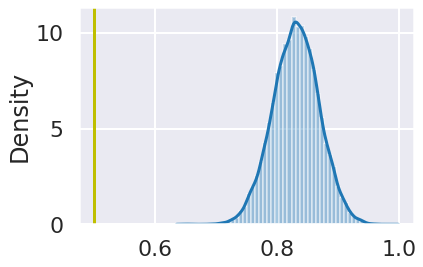

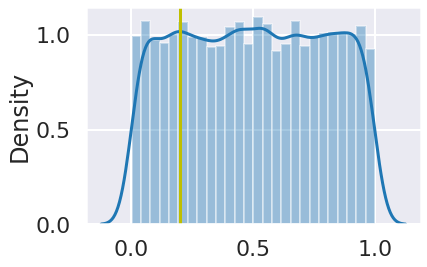

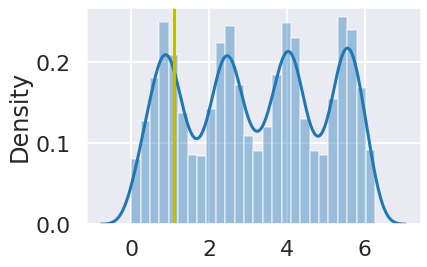

In [ ]:
for i, val in enumerate(params[0].numpy()):
  plt.figure()
  sns.distplot(bij_hmc_chains.numpy().T[i].flatten())
  # sns.distplot(non_bij_chains.numpy().T[i].flatten())
  if i ==0:
    plt.axvline(val / 8, color = 'y', label = 'true')
  else : 
    plt.axvline(val, color = 'y', label = 'true')


In [ ]:
# az.plot_trace(bij_data, figsize=(14, 4), show=True)

In [ ]:
# az.plot_posterior(
#     bij_data, point_estimate = 'median', credible_interval=0.9,
# )

In [ ]:
# true = {'x 0': 3./8, 'x 1': 0.8, 'x 2': 0.5}
# true_kwargs = {'color': 'b', 'marker' : '*' , 'markersize':18}
# # true_kwargs = {'color': 'y'}, 'x 1':  {'color': 'y'}, 'x 2':  {'color': 'y'}}

/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/pairplot.py:103: UserWarning: Argument reference_values does not include reference value for: x 5, x 4, x 3, x 6
  UserWarning,
/usr/local/lib/python3.6/dist-packages/arviz/utils.py:409: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "_cov" failed type inference due to: Untyped global name '_dot': cannot determine Numba type of <class 'arviz.utils.maybe_numba_fn'>

File "../usr/local/lib/python3.6/dist-packages/arviz/utils.py", line 421:
def _cov(data):
    <source elided>
        x -= avg[:, None]
        prod = _dot(x, x.T.conj())
        ^

  @conditional_jit(cache=True)
/usr/local/lib/python3.6/dist-packages/numba/object_mode_passes.py:178: NumbaWarning: Function "_cov" was compiled in object mode without forceobj=True.

File "../usr/local/lib/python3.6/dist-packages/arviz/utils.py", line 410:
@conditional_jit(cache=True)
def _cov(data):
^

  state.func_ir.loc

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f34dbe8eb00>,
      dtype=object)

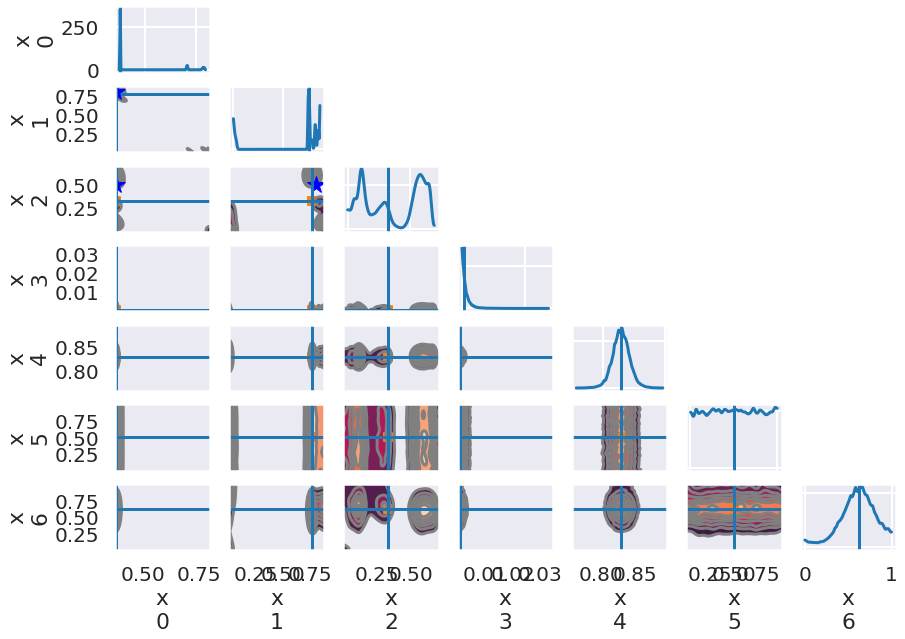

In [ ]:
# az.plot_pair(bij_data,
#              kind="kde", 
#              marginals=True,
#              figsize=(14, 10),
#              reference_values= true,
#              reference_values_kwargs = true_kwargs,
#              point_estimate="median",
#              colorbar = True,
#              textsize=20)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f34daf53400>,
      dtype=object)

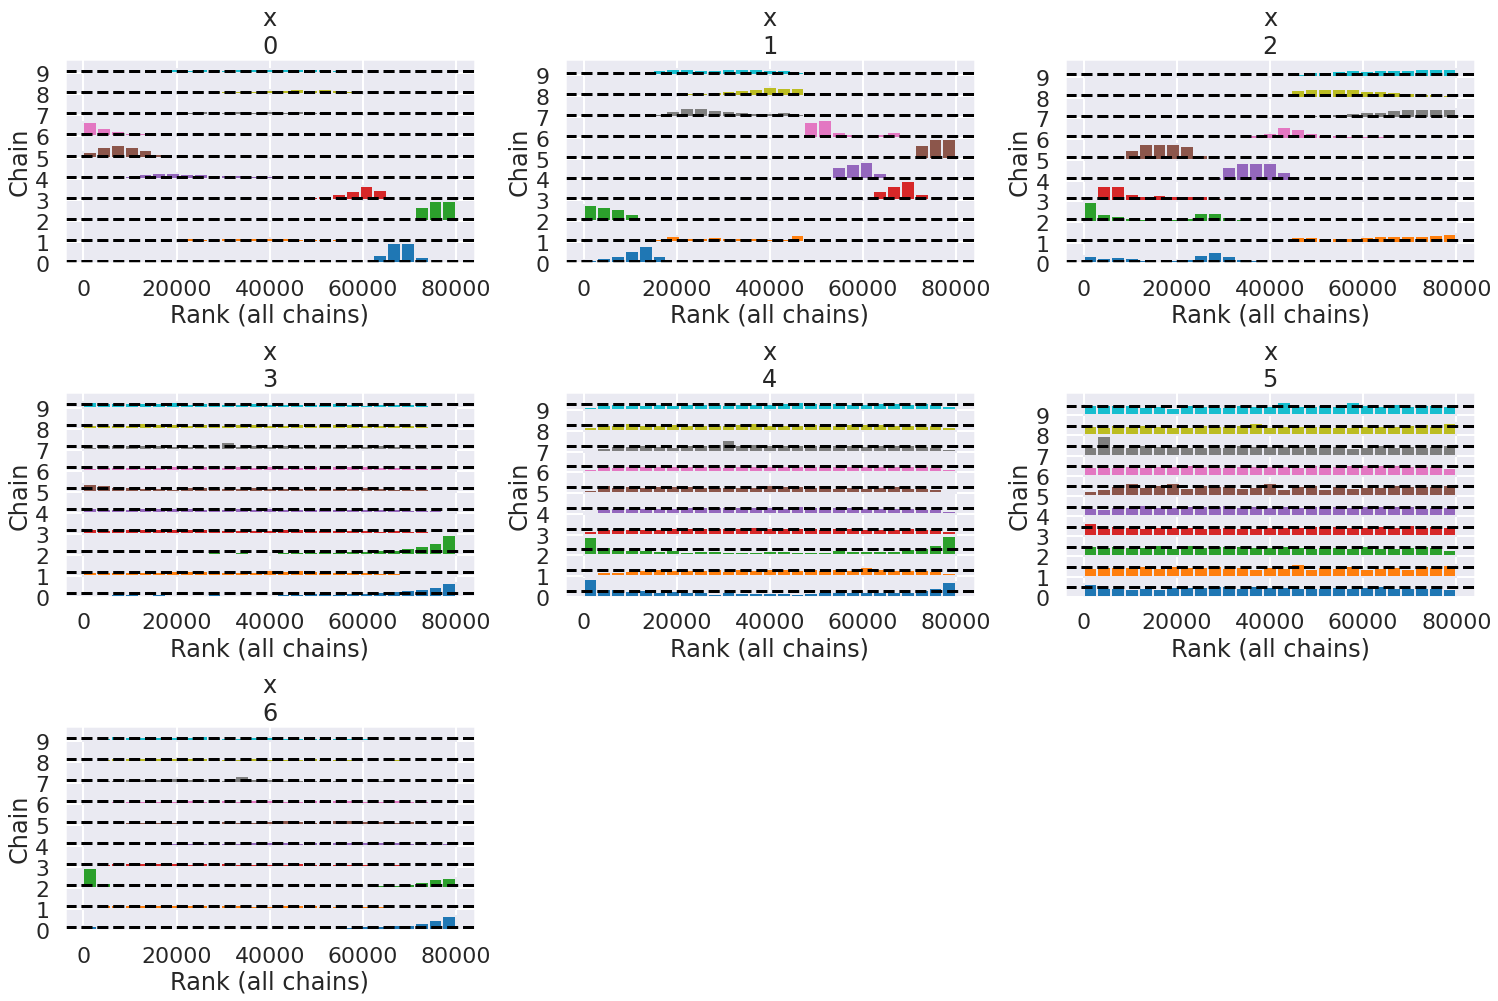

In [ ]:
# az.plot_rank(bij_data)

In [ ]:
# az.plot_ess(bij_data, kind = 'evolution')

SyntaxError: ignored

In [ ]:
# az.plot_ess(non_bij_data, kind = 'evolution')